# Adaptive Query 


Benefits of AQE - 
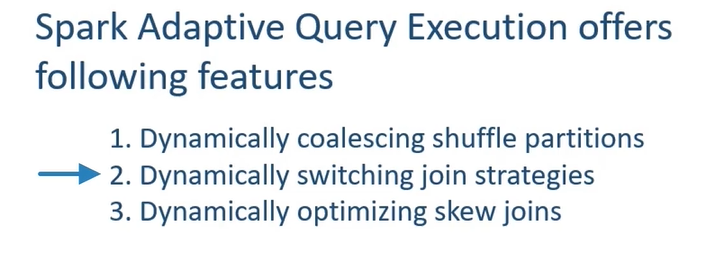

## 1. Dynamically coalesing shuffle partition

#### Bealow is an example of Spark working without and with AQE.
Without AQE, shuffle partition is se to 10 manually and we can see some empty partition need time for scheduling. Though no task is required for empty partition but it still requires scheduling and allocation of resources to these partition.

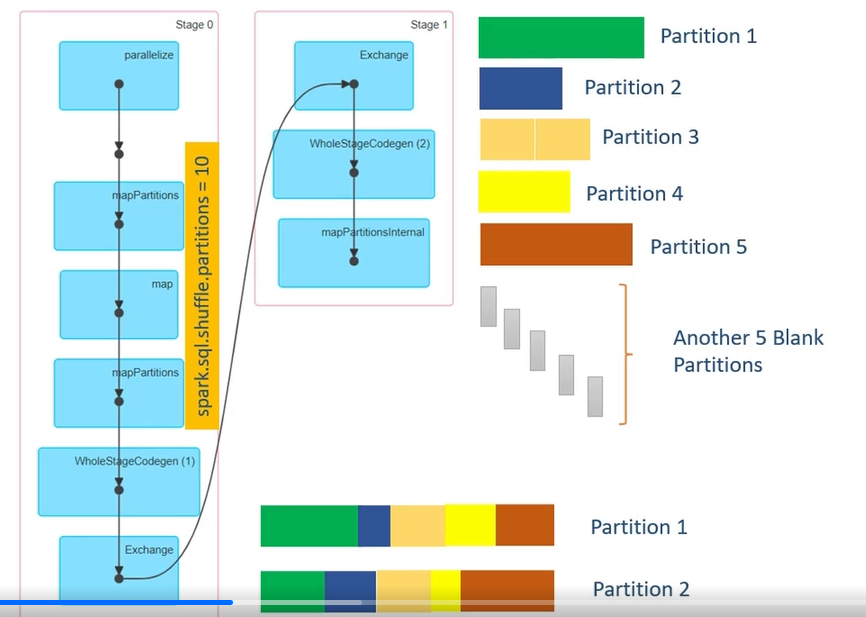

Spark 3 offeres AQE to solve this problem, AQE sets number of Shuffle partition required. Spark does it by dynamically computing statistics during shuffle sort. Dynamically determines number of shuffle partition for next stage.

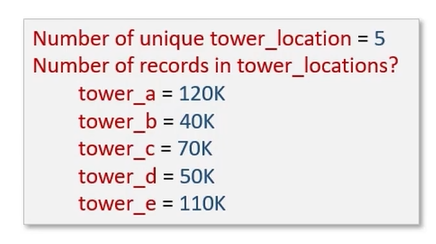




Spark merged 2 small partition to make one
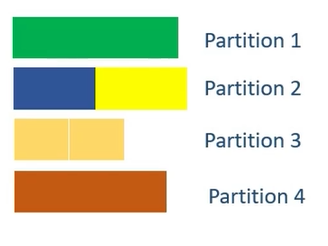

#### Summary of AQE

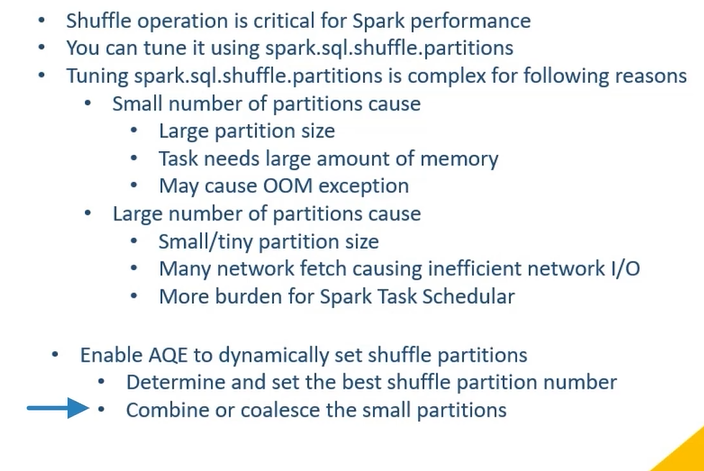

#### How to enable AQE

NOTE - Their are few more optimisation parameters with new version of spark (https://docs.databricks.com/optimizations/aqe.html)
Enabling AQE - 

1. First configuration enables AQE. Remaining four configuration is to tune the AQE.
2. Sets initial number of shuffle partition, also works as Max shuffle parition, by default value is same as spark.sql.shuffle .partition.
3. Minimum number of shuffle partition, default as 2X size of cluster core. Not recommended as setting this will override min partition size parameter.
4. Advisory size of shuffle partiotn during AQE, default is 64MB.
5. Default value is True, makes spark coalesce to work during AQE.

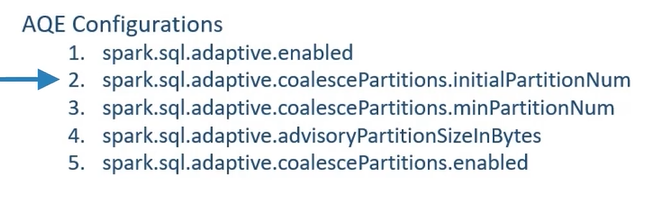



## 2. Spark AQE Dynamic join

Spark AQE calculated statistics at runtime and changes the query plan. In below example a sort merge join of 2 large tables is changed into a broadcast join at runtime as it one of the table was of 7MB after filter operation. |

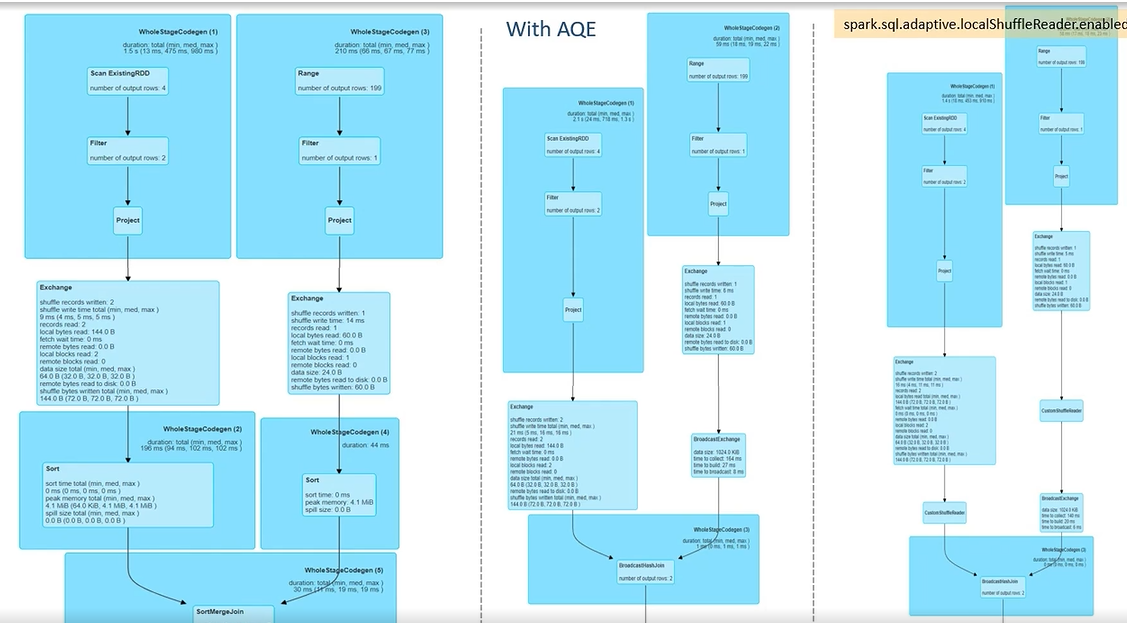

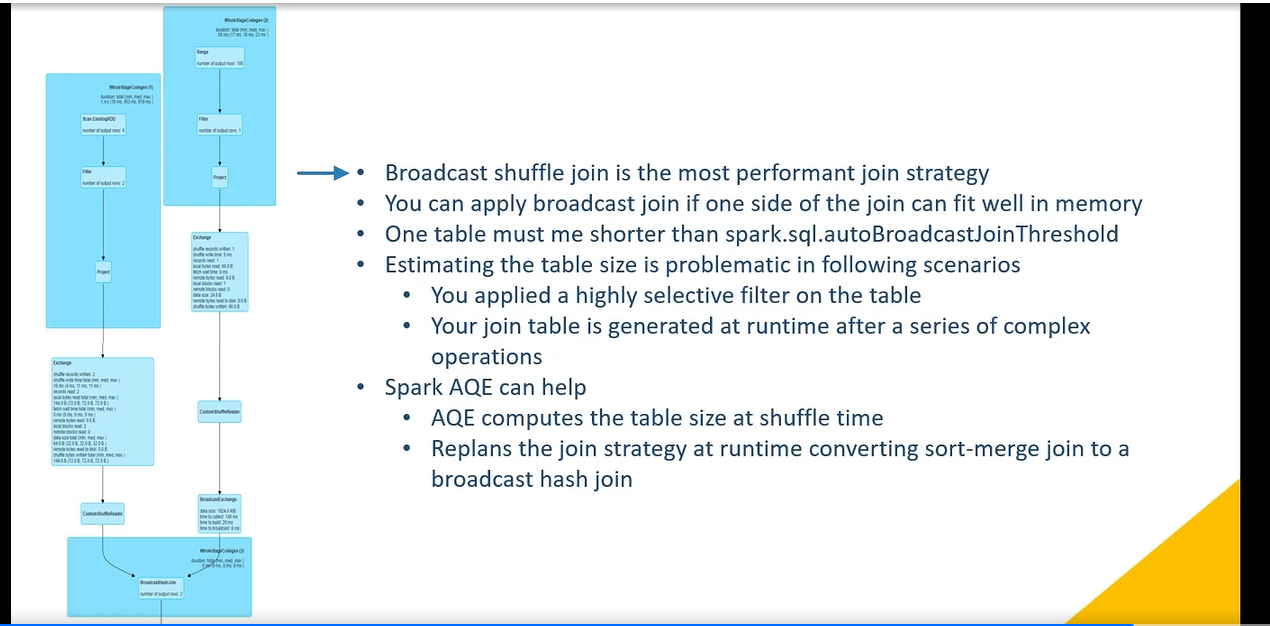

## 3. Dynamically optimising Skew join

Data skewness is solved by AQE engine spliting a skewed partiotn into multiple small(median sized) partition.

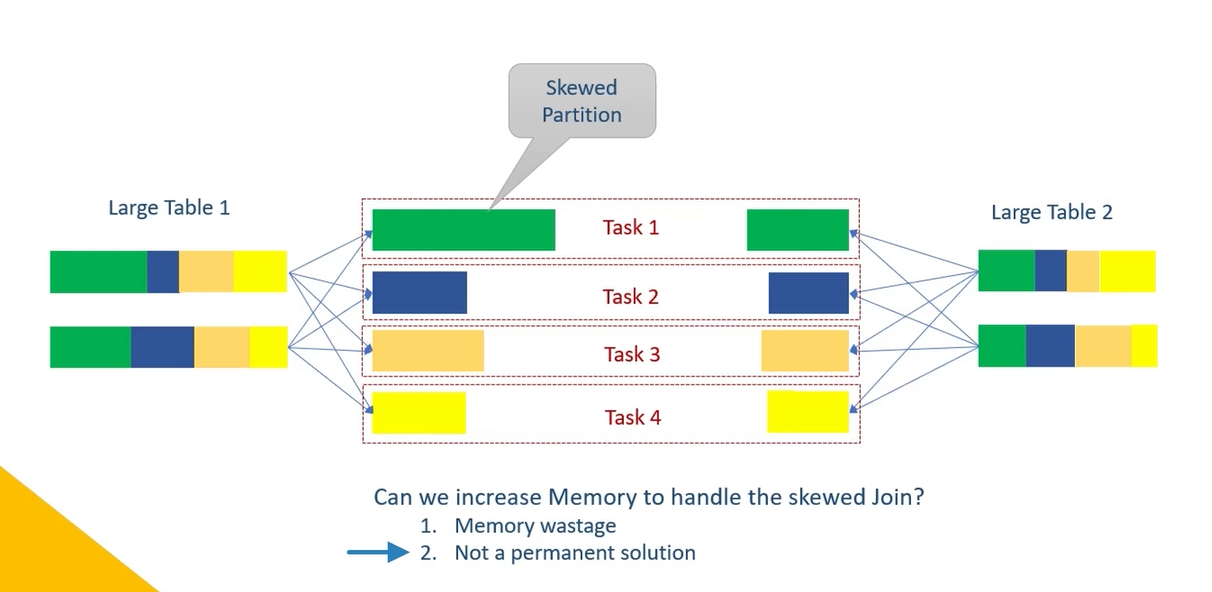

#### How AQE solves skewed partition


All below 4 configuration need to be set.

Spark AQE assumes a partition is skewed when both threshold are broken. Default value of skewed partitoin factor is 5, hence skewed partition will be split when the size of partition become 5 times more than the median of all partitions and skewed partition size is more than 256MB.

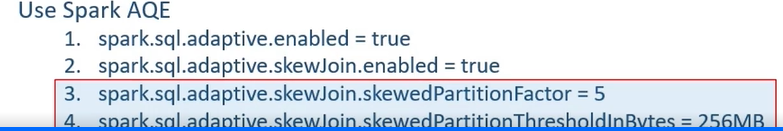

# Dynamic partition pruning

#### Why do we need partition pruning

1. Predicate Pushdown
2. Partition Pruning

Predicate pushdown, brings filter close to data scan, filter will be applied while scaning the data source. Predicate pushdown does not help much if data(column) is not partitioned. Partition pruning will prune unrequired partitions.

Dynamic partition pruning - In below query partition pruning is not applied to fact table(large table) by default. This behaviour result into scaning entire table and not only the require partition.

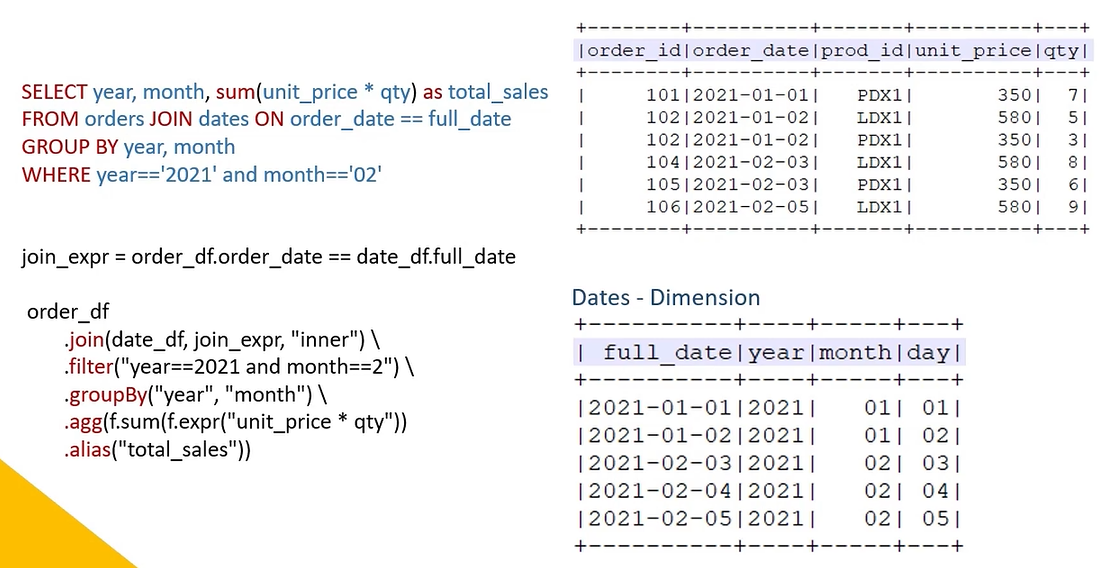

All 4 partitions are read by spark from fact table

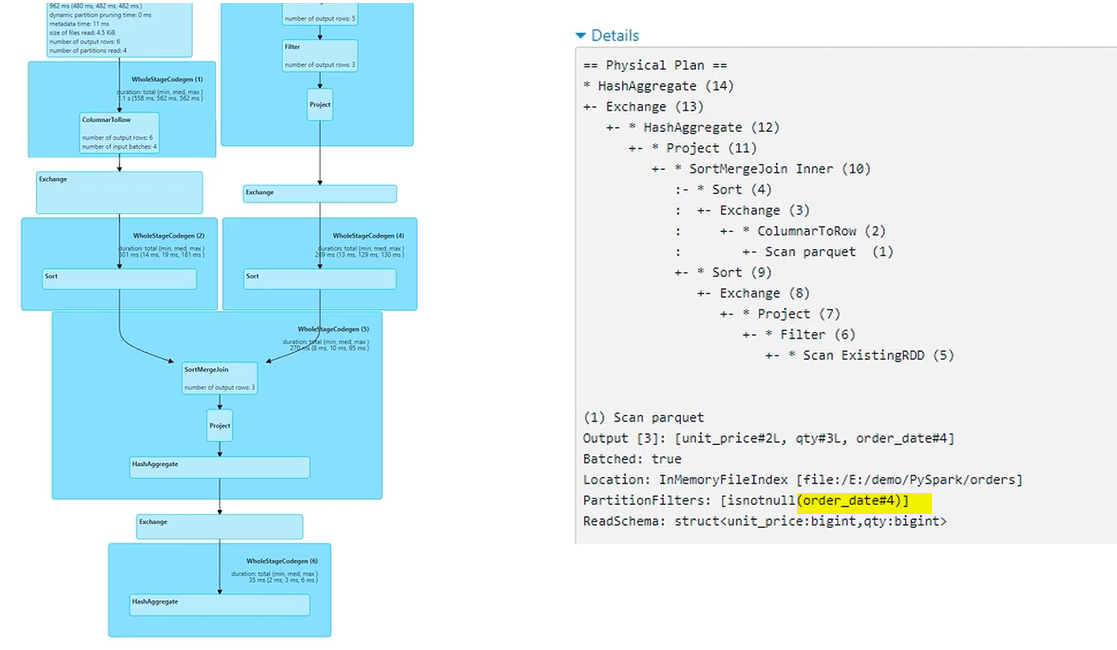

Solution - Enable Dynamic partition pruning and braodcast dimention table

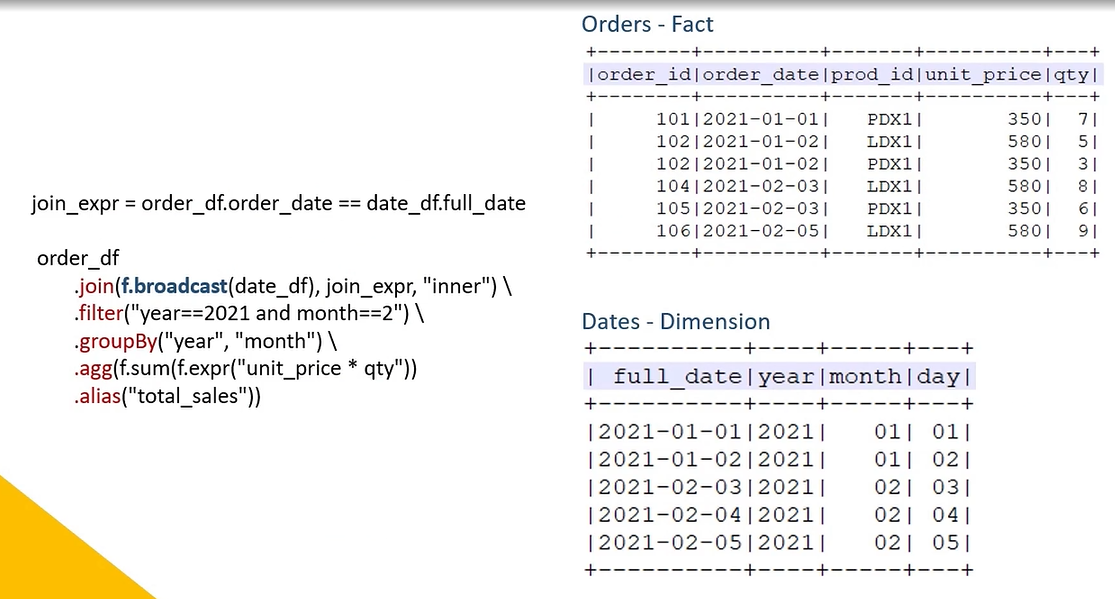

New Executuion plan 

spark took filter from dimention table and inject into fact table

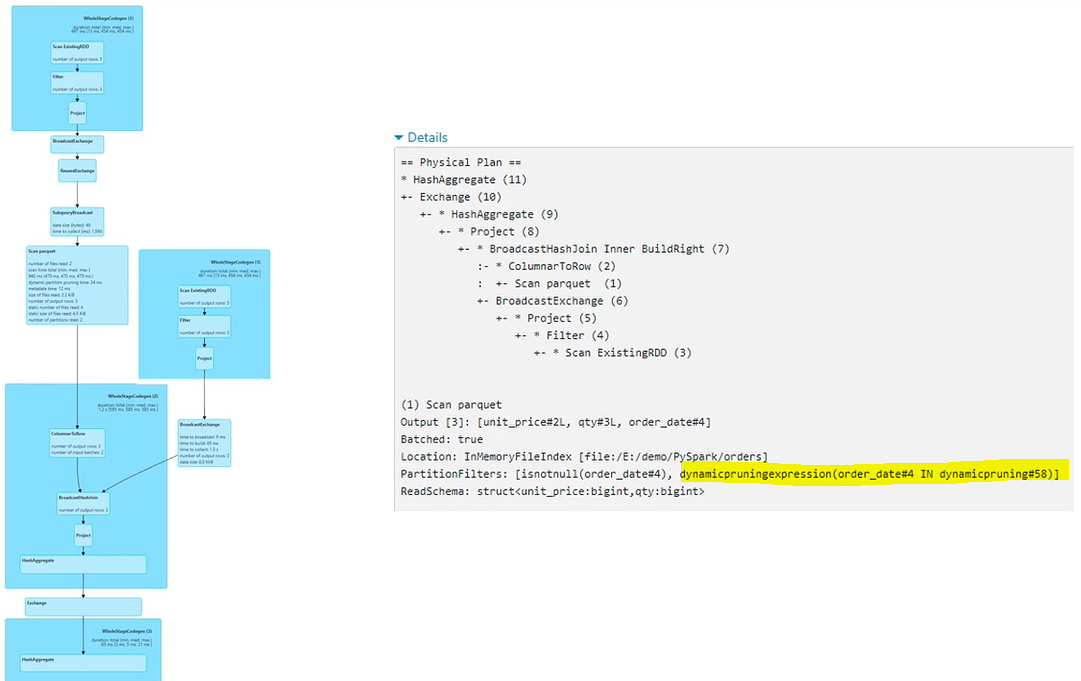

# Data caching in Spark

Data caching is a mechanism to persist dataframe in memory. It avoids recalculating of a stage which will be used by multiple action.


1. Cache doest not take any argument and stores data in memory.
2. Persist allows user to pass and argument and to persist dataframe into different storage level( memory, disk)

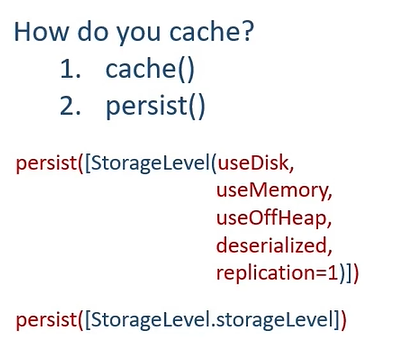

Cache and Persist are lazy transformation, which mans it will not execute until an action is called.


Note - Spark stores data in disk in a serilised form, but while in memory for use it should be deserialed into java objects.
When data is cached in memory it can cached in serialised or deserialised format. Serilised is compact while deserialised takes extra space. Though deserialation will take some CPU cycles/cost. Recommended is to persist in deserialised format and save CPU overhead. 

###### Storage level - 

Pre defining storage level

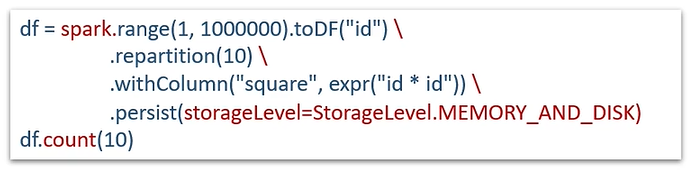


###### Different storage levels - 

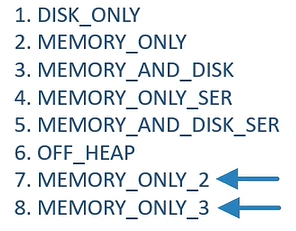

SER - Searialised.

_2/_3 - replication factor, number of copies to be stored on different executors

### uncache 

df.unpersist()

# Repartition and Coalesce

Repartition uses hash partitioning where as repartitionByRange uses range of value, it uses data sampling which meansa output will not be in same order.

Repartition is a wide dependency transformation, it uses shuffle sort to create new 10 partitions.

By default it uses spark.sql.shuffle.partition value to produce require number of partitions.

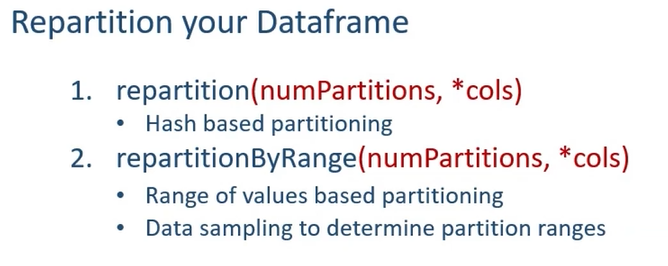

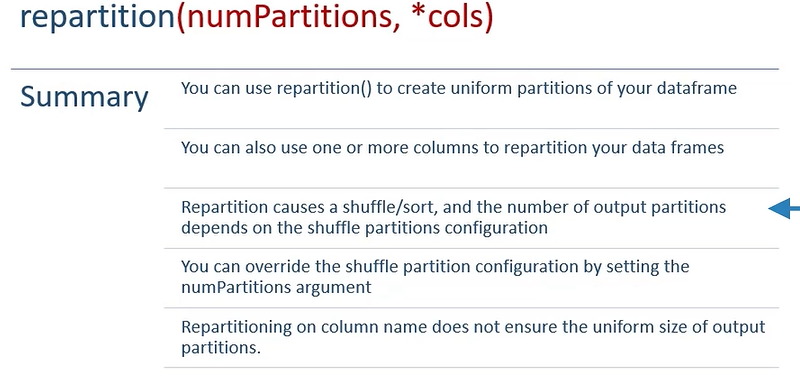

#### Coalesce 

Use Coalesce to reduce number of partition

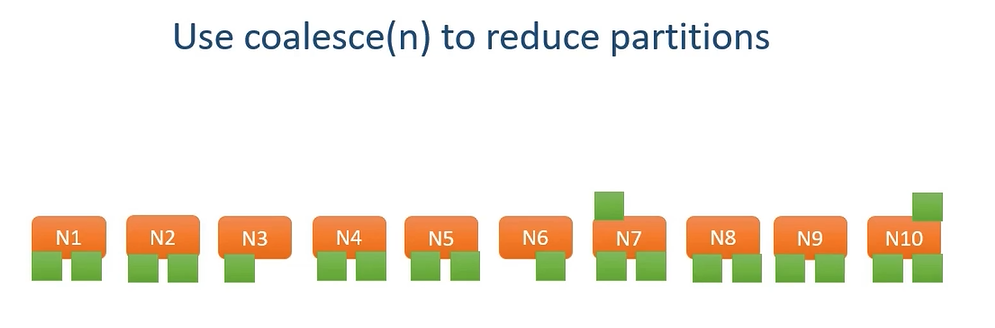


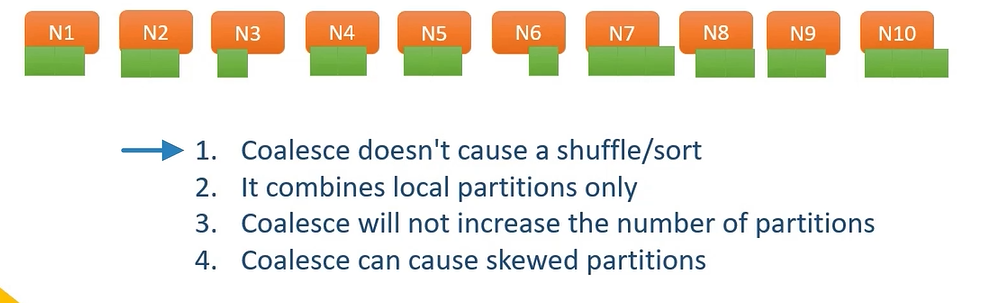

# Dataframe Hints

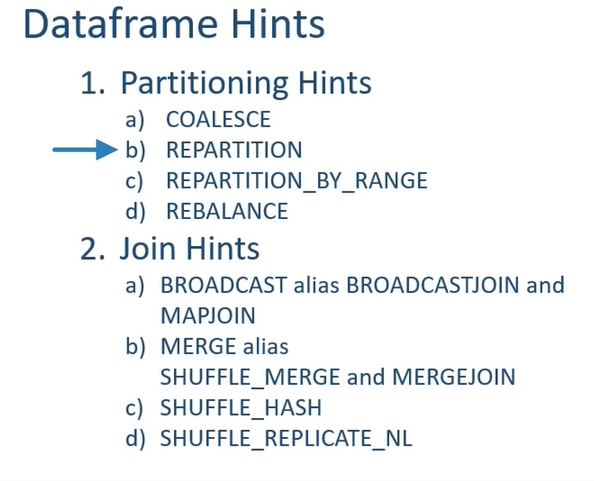

Rebalance will take column name and result in reasonable balanced sized partition. Skewed partition will be splited. AQE should be enabled.

Spark 

SHUFFLE_REPLICATE_NL - Shulffle and replicate nested join loop

#### How to use Join hints 

###### Using SQL - 

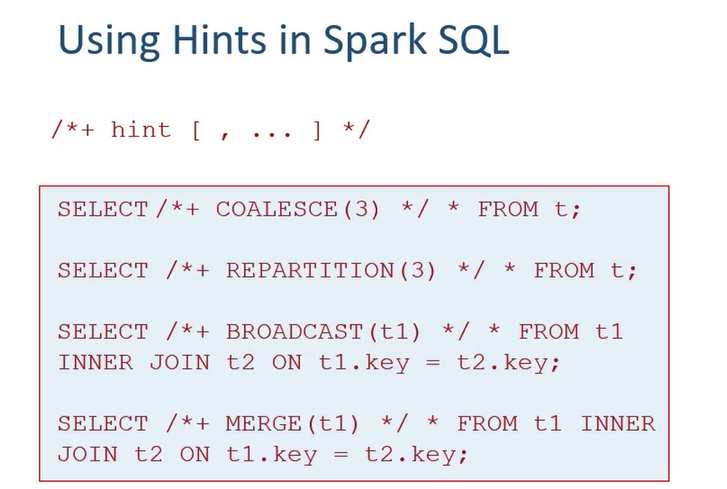


###### Using Spark API

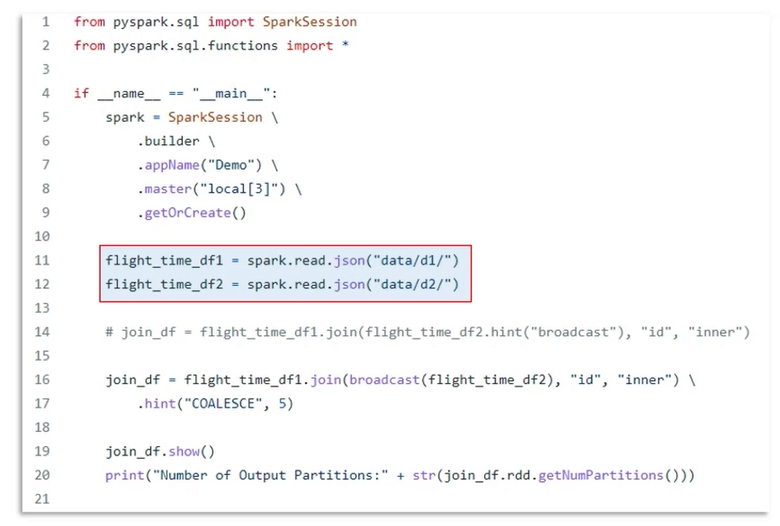

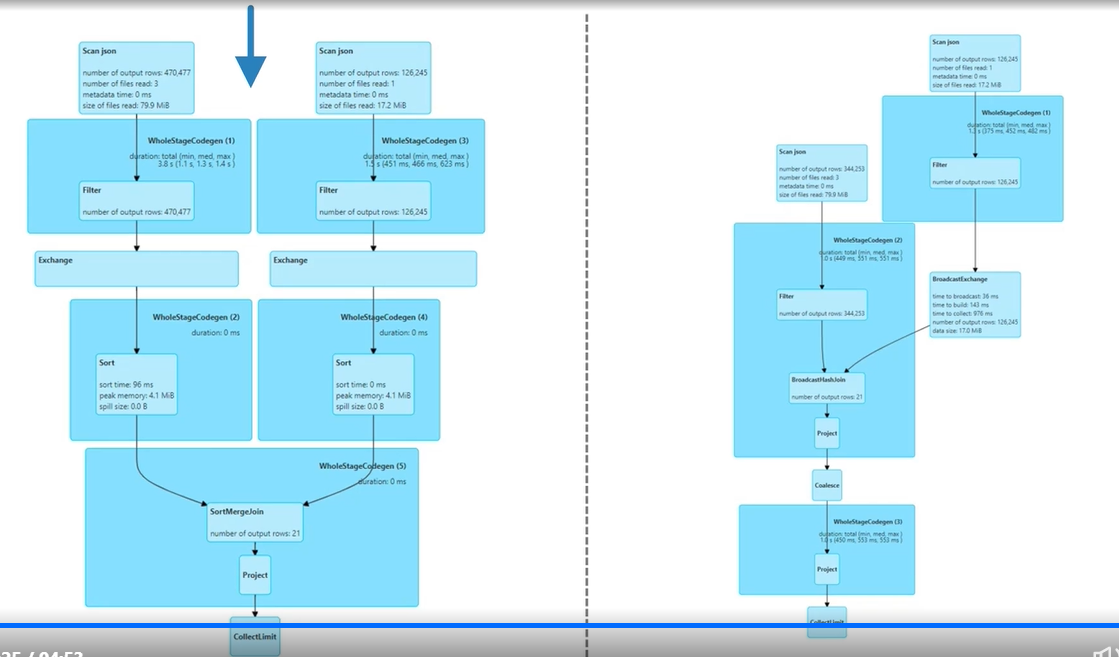

# Bradcast Vriables

Primarly used with low level RDD.

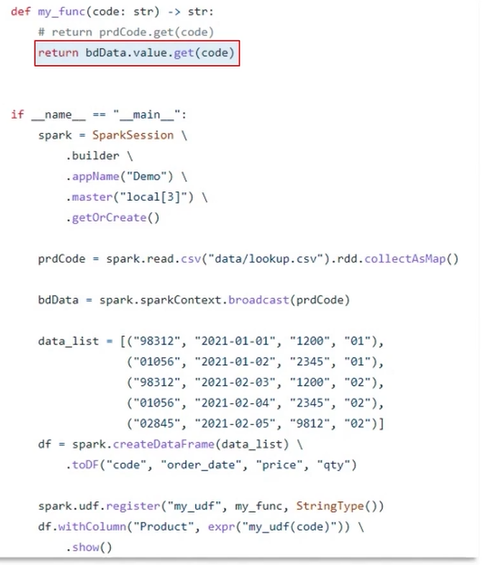


Closure and Broadcast variable both can be serialised. Closure will require variable to be serialised same as the number of task, where broadcast variable number to be serialised is equal to number of worker node.

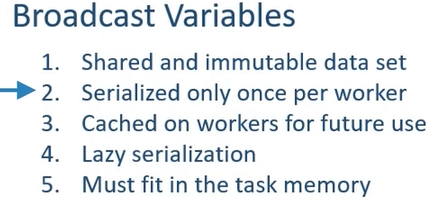

# Accumulator

Part of low level API. 

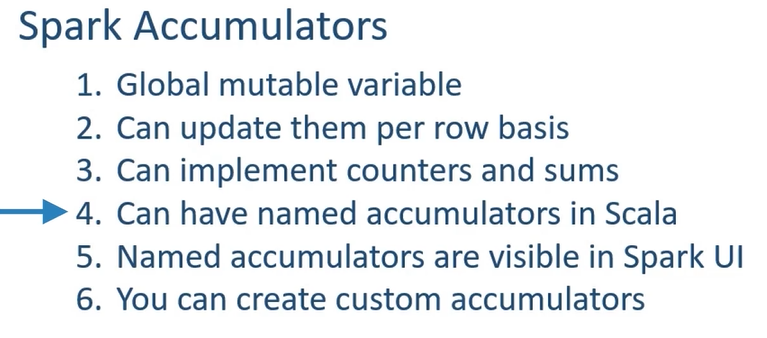

# Speculative Execution

Spark will start an duplicate task for a slow running task(due to anny problem in worked node) and accept result from the task which compltes first killing the remainng copy of the task.



# Spark Scheduling

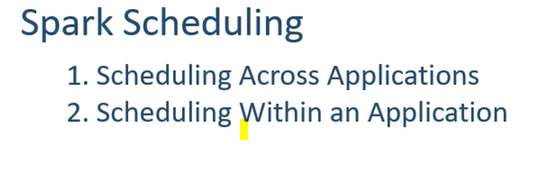

## Scheduling Across Application 


##### How cluser manager allocate resources to a Spark Application and when do they release resources? - 7

### Resource Allocation strategy 

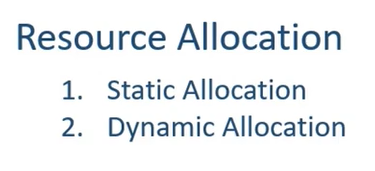

Static Allocation - As soon as the driver start it will request executer container to cluster . Cluster manager will grant all requested containers and it will be hold for entire duration. Resources will be relesed only after application is finish. This approach has a problem of resource utilisation. 





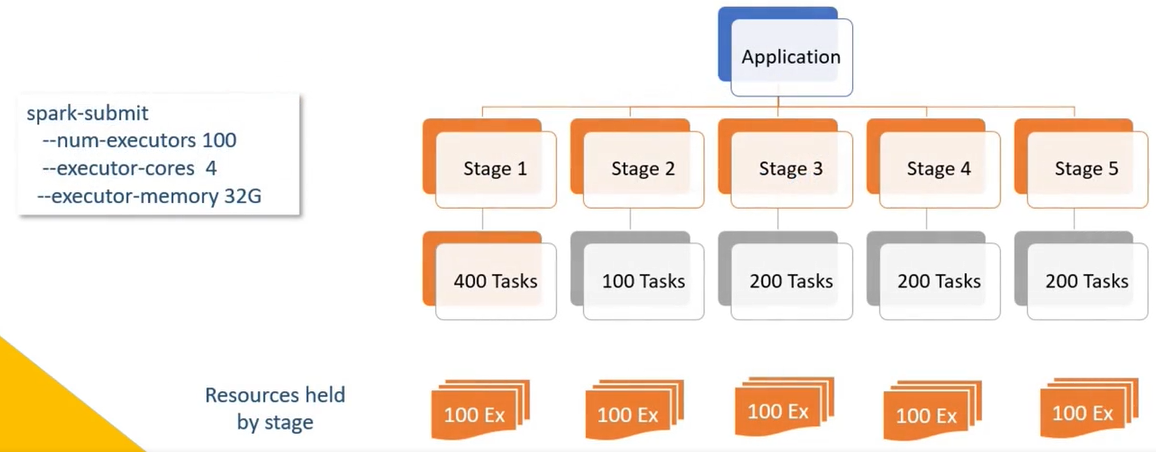

Dynamic Allocation , will release resources as soon as they are not required and demand when resources are required. Configuration to enable dynamic resource allocation.

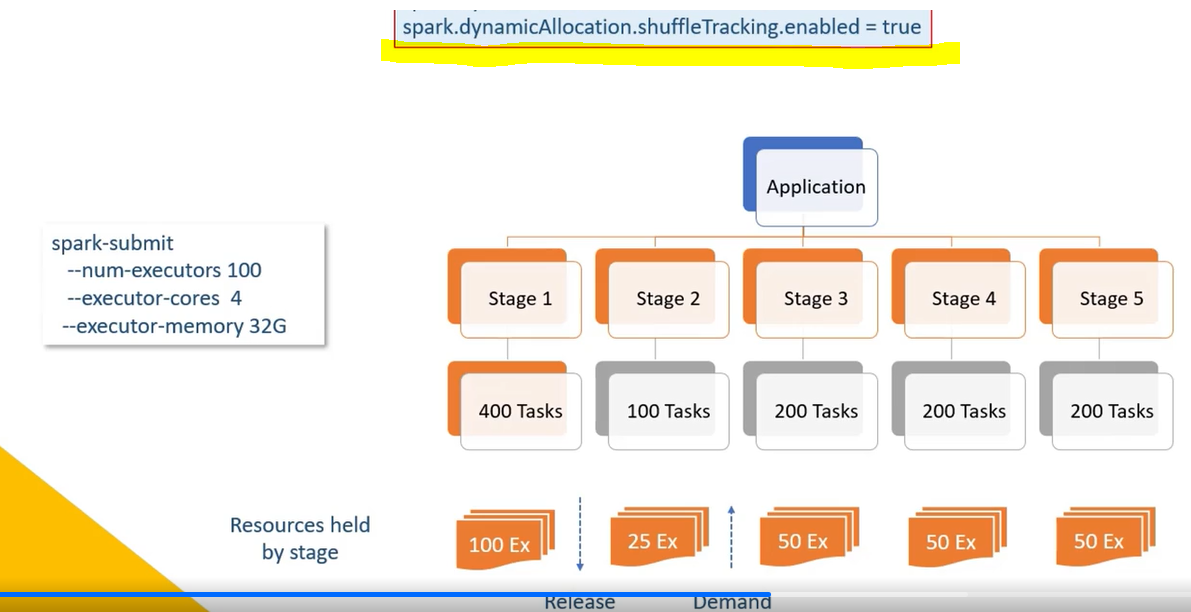

Some important variables 

first one is to relase a resource and secone one is to demand when a task is pending for execution because of resources.

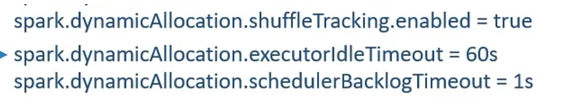

## Spark scheduling within application

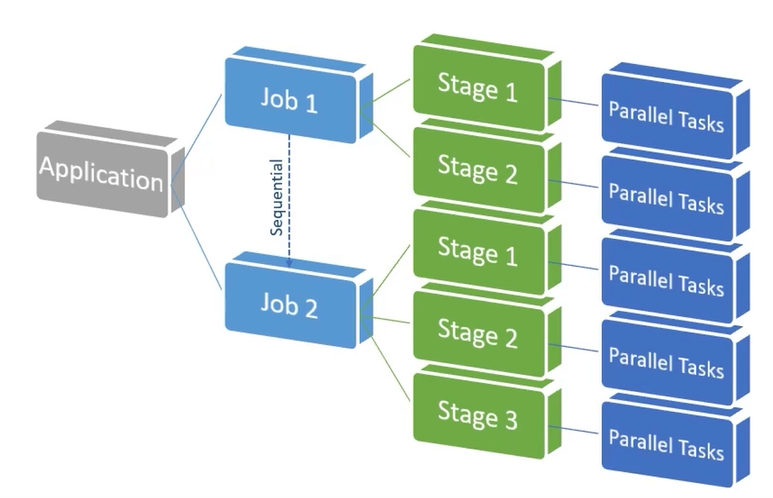

Two independent jobs are submited - 
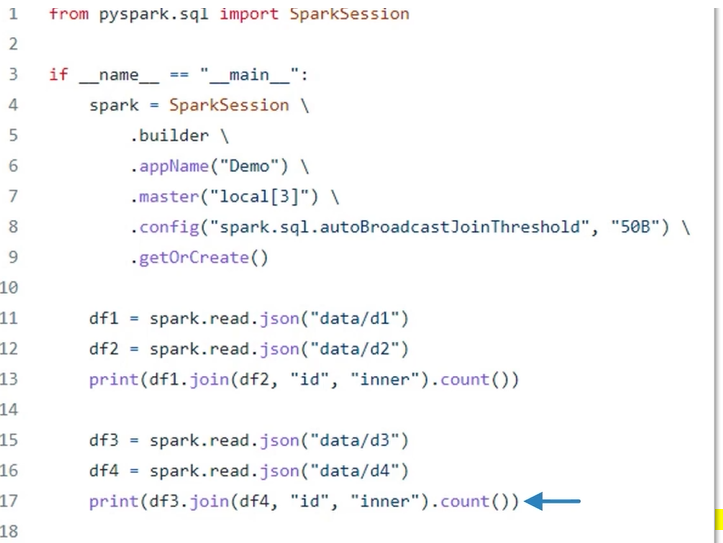

Sequential order of the jobs(look at timestamp)
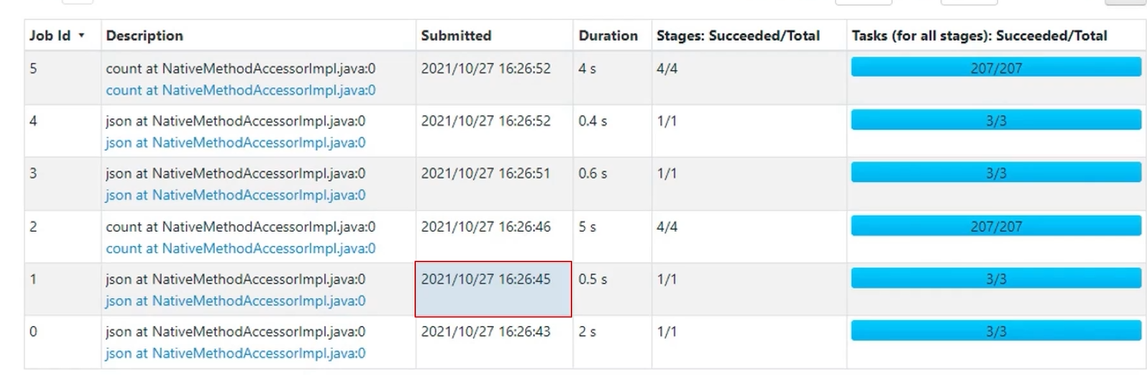

###### Parallel scheduling of jobs using threading - 

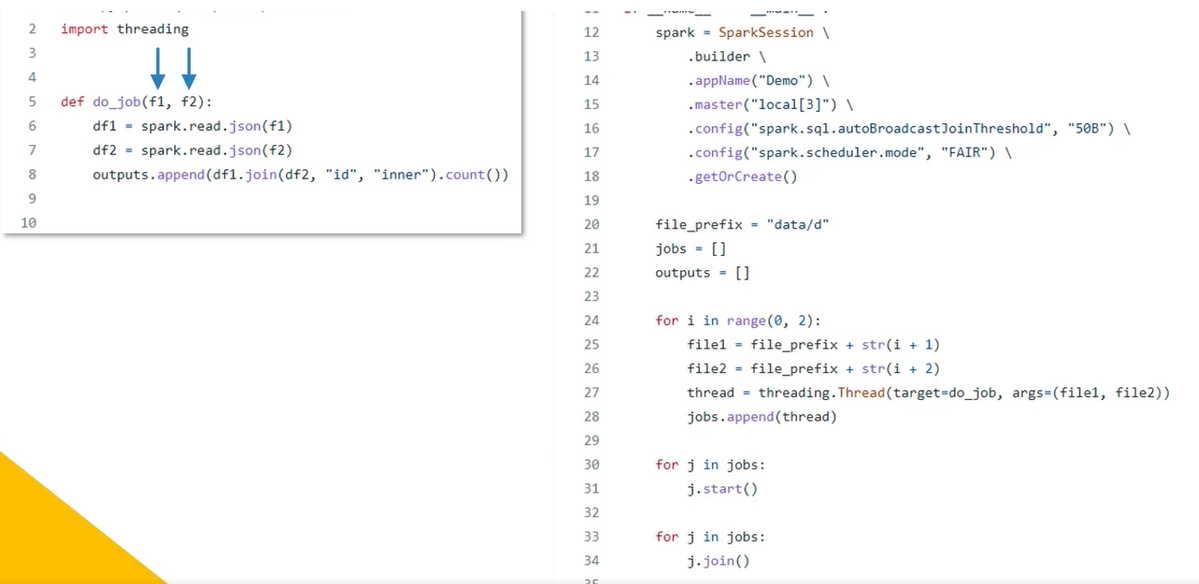

Change in time sequence in parralel mode

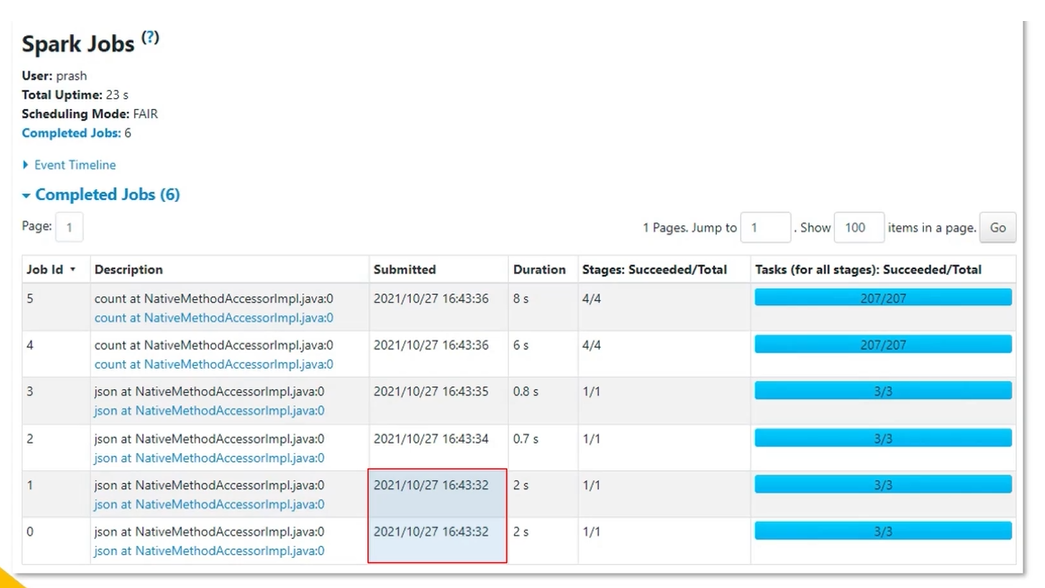

Parrallel execution will trigger an competion for resources within application. 

By default sparks job scheduler runs job in FIFO mode. This will priotise first job to allocate resouces other jobs can use leftover or wait for resources to be freed by first job.

FAIR scheduler comes in rescue here which assignes resources to jobs in round robin passion. Parallel jobs will not wait anymore.

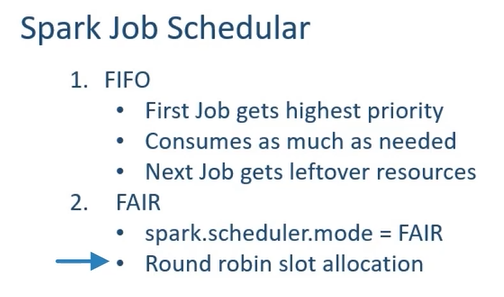

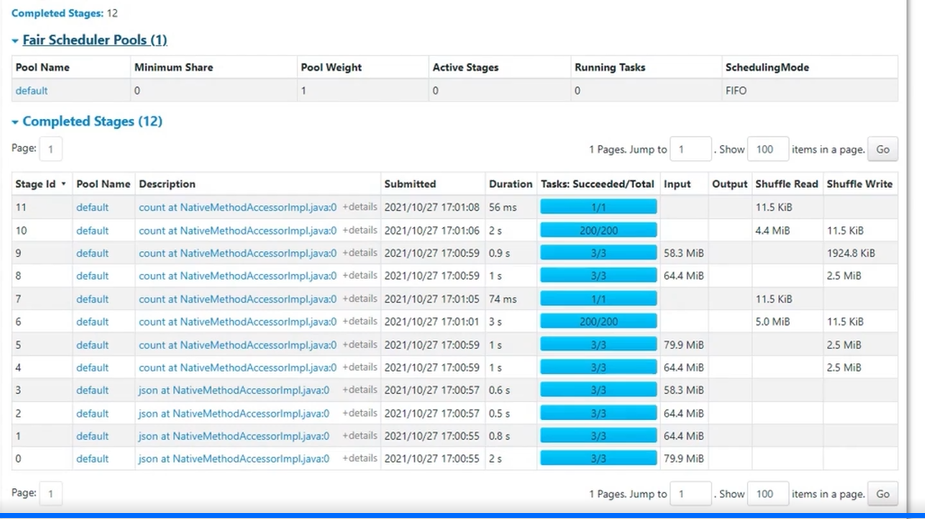